## Data Loading

In [ ]:
#DepMap Data extraction from Celligner data
import os
input_file = "D:/TCGA alighned/Celligner_aligned_data.csv" #Big file, so read line by line
#Download from https://figshare.com/articles/dataset/Celligner_data/11965269/4

output_file = "../data/Depmap_aligned.csv" #Smaller file with only DepMap samples
if not os.path.exists(output_file):
    n = 0
    with open(input_file, "r", encoding="utf-8") as infile, \
        open(output_file, "w", encoding="utf-8") as outfile:
        header = infile.readline()
        outfile.write(header)
        for line in infile:
            if line.startswith("\"ACH-"):
                outfile.write(line)
                n += 1
    print(f"Extracted {n} lines to {output_file}")
else:
    print(f"{output_file} already exists, skipping extraction") 

In [ ]:
import pandas as pd
import numpy as np
trimap = pd.read_csv("../trimap_hippo.csv", index_col=0)
cluster = pd.read_csv("../cluster_hippo.csv",index_col=0)

trimap = trimap.join(cluster)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC

df = trimap.copy()

# Features and labels
X = df[['0', '1']].values
y = df['Cluster'].values

# Fit SVM with probability estimates
clf = SVC(kernel='rbf', probability=True, gamma='scale', random_state=0)
clf.fit(X, y)

# Compute confidence (max predicted probability)
proba = clf.predict_proba(X)
confidence = proba.max(axis=1)

# Define threshold for "far from boundary"
threshold = 0.9  # adjust as needed
mask_far = confidence >= threshold

# Show selected samples
far_samples = df[mask_far]
print(far_samples)


In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df['0'], df['1'], c='lightgray', label='All samples')
plt.scatter(far_samples['0'], far_samples['1'], c='red', label='Far from boundary')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
df_exp = pd.read_csv("../data/Depmap_aligned.csv",index_col=0) 
cluster = pd.read_csv("../cluster_hippo.csv",index_col=0)
clusterdic = {id: cluster.loc[id,"Cluster"] for id in cluster.index}

from sklearn.preprocessing import StandardScaler
df_exp_dep = df_exp[[d in clusterdic for d in df_exp.index]].dropna(axis=1,how="any").copy()
df_exp_dep = df_exp_dep.loc[:, df_exp_dep.std() != 0]
scaler= StandardScaler().fit(df_exp_dep)
normalized = scaler.transform(df_exp_dep)
df_exp_dep = pd.DataFrame(normalized, index=df_exp_dep.index, columns=df_exp_dep.columns)


In [ ]:
df_exp_dep = df_exp_dep[df_exp_dep.index.isin(far_samples.index)]

In [ ]:
info = pd.read_csv("D:/TCGA alighned/Celligner_info.csv")
id_to_lineage = {id:lin for id, lin in zip(info["sampleID"], info["lineage"])}
id_to_subtype = {id:f'{lin}_{sub}' for id, lin, sub in zip(info["sampleID"], info["lineage"], info["subtype"])}

## Machine learning (Fig. S8b, c, d)

In [ ]:
"""df_exp_dep2 = df_exp_dep.copy()
for lin in set(id_to_lineage.values()):
    df_exp_dep2[lin] = [1 if id_to_lineage[d]==lin else 0 for d in df_exp_dep2.index]
df_exp_dep2.head()

X = df_exp_dep2.values
y = [clusterdic[d] for d in df_exp_dep.index]"""

In [ ]:
np.save("../data/X_reduced_clinical.npy", X_reduced)
np.save("../data/y_clinical.npy", y)


In [194]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
df_exp_dep2 = df_exp_dep.copy()
X_gene = df_exp_dep2.values
# add lineage columns
lineage_cols = []

for lin in set(id_to_lineage.values()):
    df_exp_dep2[lin] = [1 if id_to_lineage[d]==lin else 0 for d in df_exp_dep2.index]
    if sum(df_exp_dep2[lin]) < 10:
       df_exp_dep2.drop(columns=lin, inplace=True)
    else:
        lineage_cols.append(lin)

for sub in set(id_to_subtype.values()):
    df_exp_dep2[sub] = [1 if id_to_subtype[d]==sub else 0 for d in df_exp_dep2.index]
    if sum(df_exp_dep2[sub]) < 10:
        df_exp_dep2.drop(columns=sub, inplace=True)
    else:
        lineage_cols.append(sub)

#lineage_cols = list(set(id_to_lineage.values()))+list(set(id_to_subtype.values()))
#ineage_cols = list(set(id_to_lineage.values()))

X_lineage = df_exp_dep2[lineage_cols].values
y = np.array([clusterdic[d] for d in df_exp_dep2.index])



In [ ]:
lineage_cols

In [ ]:
df_exp_dep2.sum()

In [ ]:
from sklearn.feature_selection import f_classif
from itertools import combinations
import numpy as np

selected = set()
a = []

for cls1, cls2 in combinations(np.unique(y), 2):
    mask = np.isin(y, [cls1, cls2])
    X_sub = X_gene[mask]
    y_sub = y[mask]
    y_bin = (y_sub == cls2).astype(int)
    f_vals, _ = f_classif(X_sub, y_bin)
    top = np.argsort(np.nan_to_num(f_vals))[-30:]
    selected.update(top)
    a.append(top)
X_gene_reduced = X_gene[:, sorted(selected)]
X_reduced = np.hstack([X_gene_reduced, X_lineage])


In [ ]:
len(X_reduced[0])

In [ ]:
df_exp_dep.columns.tolist()[list(a[2])]

In [ ]:
len(far_samples),len(y)

In [ ]:
len(X_gene_reduced[0]), len(X_reduced[0])

In [ ]:
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import numpy as np
import warnings
from imblearn.combine import SMOTETomek
models = {
    "LogisticRegression000001": LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, C=0.00001),
    "LogisticRegression00001": LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, C=0.0001),
    "LogisticRegression0001": LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, C=0.001),
    #"LogisticRegression00005": LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, C=0.0005),
    #"LogisticRegression00002": LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, C=0.0002),
    "LogisticRegression005": LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, C=0.05),
    "LogisticRegression001": LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, C=0.01),
    #"LogisticRegression01": LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, C=0.1),
    #"LogisticRegression1": LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, C=1),
    #"RandomForest": RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42, n_jobs=-1, max_depth=4),
    #"XGBoost10": XGBClassifier(use_label_encoder=False, learning_rate=0.05, eval_metric='mlogloss', max_depth=3, subsample=1, random_state=42, n_jobs=-1, reg_lambda=1, reg_alpha=1, gamma=10),
    "XGBoost30": XGBClassifier(use_label_encoder=False, learning_rate=0.05, eval_metric='mlogloss', max_depth=3, subsample=0.8, random_state=42, n_jobs=-1, reg_lambda=0.3, gamma=10),
    #"XGBoost_MildReg": XGBClassifier(use_label_encoder=False, learning_rate=0.05, eval_metric='mlogloss', max_depth=2, subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, gamma=5, min_child_weight=3, random_state=42, n_jobs=-1),
    #"XGBoost_StrongReg": XGBClassifier(use_label_encoder=False, learning_rate=0.03, eval_metric='mlogloss', max_depth=3, subsample=0.7, colsample_bytree=0.7, reg_lambda=2.0, gamma=10, min_child_weight=5, random_state=42, n_jobs=-1),
    "XGBoost_Dropout": XGBClassifier(use_label_encoder=False, learning_rate=0.05, eval_metric='mlogloss', max_depth=3, subsample=0.6, colsample_bytree=0.6, reg_lambda=0.5, gamma=8, min_child_weight=2, random_state=42, n_jobs=-1),
    #"XGBoost_L1mix": XGBClassifier(use_label_encoder=False, learning_rate=0.05, eval_metric='mlogloss', max_depth=3, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.5, reg_lambda=0.5, gamma=10, random_state=42, n_jobs=-1),
    #"XGBoost_VeryDrop": XGBClassifier(use_label_encoder=False, learning_rate=0.03, eval_metric='mlogloss', max_depth=2, subsample=0.6, colsample_bytree=0.6, reg_lambda=1.0, gamma=8, min_child_weight=4, random_state=42, n_jobs=-1),
    ##"XGBoost_L1L2Strong": XGBClassifier(use_label_encoder=False, learning_rate=0.04, eval_metric='mlogloss', max_depth=3, subsample=0.7, colsample_bytree=0.8, reg_alpha=1.0, reg_lambda=2.0, gamma=8, min_child_weight=3, random_state=42, n_jobs=-1),
    #"XGBoost_SoftDepth": XGBClassifier(use_label_encoder=False, learning_rate=0.05, eval_metric='mlogloss', max_depth=4, subsample=0.8, colsample_bytree=0.8, reg_lambda=0.5, gamma=10, min_child_weight=2, random_state=42, n_jobs=-1),
}

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, model in models.items():
        print(f"\nModel: {name}")
        acc_train, acc_val = [], []
        bal_train, bal_val = [], []
        
        for train_idx, val_idx in cv.split(X_reduced, y):
            X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
            y_train, y_val = np.array(y)[train_idx], np.array(y)[val_idx]
            
            #pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('model', model)])
            pipeline = Pipeline([('smote', SMOTETomek(random_state=0)), ('model', model)])
            pipeline.fit(X_train, y_train)
            
            # training and validation predictions
            y_pred_train = pipeline.predict(X_train)
            y_pred_val = pipeline.predict(X_val)
            
            acc_train.append(accuracy_score(y_train, y_pred_train))
            acc_val.append(accuracy_score(y_val, y_pred_val))
            bal_train.append(balanced_accuracy_score(y_train, y_pred_train))
            bal_val.append(balanced_accuracy_score(y_val, y_pred_val))
        
        print(f" Train Acc: {np.mean(acc_train):.3f} | Val Acc: {np.mean(acc_val):.3f}")
        print(f" Train BalAcc: {np.mean(bal_train):.3f} | Val BalAcc: {np.mean(bal_val):.3f}")
        
        results.append({
            "Method": name,
            "Train Accuracy": np.mean(acc_train),
            "Val Accuracy": np.mean(acc_val),
            "Train Balanced Acc": np.mean(bal_train),
            "Val Balanced Acc": np.mean(bal_val)
        })

df_results = pd.DataFrame(results)


In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.datasets import make_classification  # Using this to create sample data
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, make_scorer

# --- New Imports for Bayesian Optimization ---
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=0)),
    ('model', XGBClassifier(use_label_encoder=False, 
                            eval_metric='mlogloss', 
                            random_state=42, 
                            n_jobs=-1))
])

def print_bal_acc(y_true, y_pred):
    score = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy: {score:.4f}")
    return score

scorer = make_scorer(print_bal_acc, greater_is_better=True)

# --- 3. Define the Bayesian Search Space ---
# This is where you set the ranges for the optimizer to explore.
# We use the 'model__' prefix to tell BayesSearchCV to pass these
# parameters to the 'model' step of our pipeline.
search_space = {
    'model__learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'model__max_depth': Integer(2, 6),
    'model__subsample': Real(0.2, 1.0, 'uniform'),
    'model__colsample_bytree': Real(0.2, 1.0, 'uniform'),
    'model__reg_lambda': Real(0.1, 10.0, 'log-uniform'),  # L2 regularization
    'model__reg_alpha': Real(0.0, 5.0, 'uniform'),        # L1 regularization
    'model__gamma': Real(1, 10.0, 'uniform'),
    'model__n_estimators': Integer(100, 300)
}

# --- 4. Set up BayesSearchCV ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# We'll optimize for 'balanced_accuracy'
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=100,  # Number of parameter settings to try
    scoring=scorer,
    cv=cv,
    n_jobs=1,  # Use all available cores
    random_state=0,
    verbose=0   # Set to 1 or 2 for more output
)

# --- 5. Run the Optimization ---
print("Running Bayesian Optimization...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt.fit(X_reduced, y)

# --- 6. Show the Results ---
print("\n--- Optimization Complete ---")
print(f"Best parameters found:\n{opt.best_params_}")
print(f"\nBest 5-fold CV Balanced Accuracy: {opt.best_score_:.4f}")

# You can also get a nice DataFrame of all results
df_results = pd.DataFrame(opt.cv_results_)
df_results = df_results.sort_values(by='mean_test_score', ascending=False)

print("\nTop 5 results from the optimization search:")
print(df_results[['params', 'mean_test_score', 'std_test_score']].head())

In [ ]:
import pandas as pd
import numpy as np
import warnings
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# --- Define pipeline ---
pipeline_lr = Pipeline([
    ('smote', SMOTETomek(random_state=0)),
    ('model', LogisticRegression(
        solver='saga',        # supports L1/L2 penalties
        max_iter=4000,
        random_state=42,
        n_jobs=-1
    ))
])

# --- Custom scorer ---
def print_bal_acc(y_true, y_pred):
    score = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy: {score:.4f}")
    return score

scorer = make_scorer(print_bal_acc, greater_is_better=True)

# --- Search space ---
search_space_lr = {
    'model__penalty': Categorical(['l1', 'l2', 'elasticnet', None]),
    'model__C': Real(1e-3, 1e+2, prior='log-uniform'),   # inverse regularization strength
    'model__l1_ratio': Real(0.0, 1.0, prior='uniform'),  # only used if penalty='elasticnet'
}

# --- Cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# --- BayesSearchCV setup ---
opt_lr = BayesSearchCV(
    estimator=pipeline_lr,
    search_spaces=search_space_lr,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=1,
    random_state=0,
    verbose=0
)

# --- Run the optimization ---
print("Running Bayesian Optimization (Logistic Regression)...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt_lr.fit(X_reduced, y)

# --- Results ---
print("\n--- Optimization Complete ---")
print(f"Best parameters found:\n{opt_lr.best_params_}")
print(f"\nBest 5-fold CV Balanced Accuracy: {opt_lr.best_score_:.4f}")

df_results_lr = pd.DataFrame(opt_lr.cv_results_).sort_values(
    by='mean_test_score', ascending=False)
print("\nTop 5 results from the optimization search:")
print(df_results_lr[['params', 'mean_test_score', 'std_test_score']].head())


In [ ]:
import pandas as pd
import numpy as np
import warnings
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# --- Define pipeline ---
pipeline_rf = Pipeline([
    ('smote', SMOTETomek(random_state=0)),
    ('model', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

# --- Custom scorer ---
def print_bal_acc(y_true, y_pred):
    score = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy: {score:.4f}")
    return score

scorer = make_scorer(print_bal_acc, greater_is_better=True)

# --- Search space for Random Forest ---
search_space_rf = {
    'model__n_estimators': Integer(100, 500),
    'model__max_depth': Integer(2, 20),
    'model__min_samples_split': Integer(2, 20),
    'model__min_samples_leaf': Integer(1, 10),
    'model__max_features': Real(0.3, 1.0, prior='uniform'),
    'model__bootstrap': Categorical([True, False]),
    'model__criterion': Categorical(['gini', 'entropy', 'log_loss'])
}

# --- Cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# --- BayesSearchCV setup ---
opt_rf = BayesSearchCV(
    estimator=pipeline_rf,
    search_spaces=search_space_rf,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=1,    # set = -1 if you don't need print() output
    random_state=0,
    verbose=0
)

# --- Run the optimization ---
print("Running Bayesian Optimization (Random Forest)...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt_rf.fit(X_reduced, y)

# --- Results ---
print("\n--- Optimization Complete ---")
print(f"Best parameters found:\n{opt_rf.best_params_}")
print(f"\nBest 5-fold CV Balanced Accuracy: {opt_rf.best_score_:.4f}")

df_results_rf = pd.DataFrame(opt_rf.cv_results_).sort_values(
    by='mean_test_score', ascending=False)

print("\nTop 5 results from the optimization search:")
print(df_results_rf[['params', 'mean_test_score', 'std_test_score']].head())


In [ ]:
import pandas as pd
import numpy as np
import warnings
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# --- Define pipeline ---
pipeline_svm = Pipeline([
    ('smote', SMOTETomek(random_state=0)),
    ('model', SVC(probability=True, random_state=42))
])

# --- Custom scorer ---
def print_bal_acc(y_true, y_pred):
    score = balanced_accuracy_score(y_true, y_pred)
    print(f"Balanced Accuracy: {score:.4f}")
    return score

scorer = make_scorer(print_bal_acc, greater_is_better=True)

# --- Search space for SVM ---
# You can tune kernel type, C, gamma, and degree (for poly)
search_space_svm = {
    'model__kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid']),
    'model__C': Real(1e-3, 1e+3, prior='log-uniform'),
    'model__gamma': Real(1e-4, 1e-1, prior='log-uniform'),
    'model__degree': Integer(2, 5),  # only used for 'poly'
    'model__coef0': Real(0.0, 1.0, prior='uniform')  # affects 'poly' and 'sigmoid'
}

# --- Cross-validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# --- BayesSearchCV setup ---
opt_svm = BayesSearchCV(
    estimator=pipeline_svm,
    search_spaces=search_space_svm,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=1,    # use -1 for full parallel, but print() may disappear
    random_state=0,
    verbose=0
)

# --- Run the optimization ---
print("Running Bayesian Optimization (SVM)...")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt_svm.fit(X_reduced, y)

# --- Results ---
print("\n--- Optimization Complete ---")
print(f"Best parameters found:\n{opt_svm.best_params_}")
print(f"\nBest 5-fold CV Balanced Accuracy: {opt_svm.best_score_:.4f}")

df_results_svm = pd.DataFrame(opt_svm.cv_results_).sort_values(
    by='mean_test_score', ascending=False)

print("\nTop 5 results from the optimization search:")
print(df_results_svm[['params', 'mean_test_score', 'std_test_score']].head())


In [ ]:
import pandas as pd

output_path = '../result/optimized_results_1vs1f.xlsx'

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    df_results.to_excel(writer, sheet_name='Results_XGB', index=False)
    df_results_lr.to_excel(writer, sheet_name='Results_LR', index=False)
    df_results_rf.to_excel(writer, sheet_name='Results_RF', index=False)
    df_results_svm.to_excel(writer, sheet_name='Results_SVM', index=False)

print(f"Results saved to: {output_path}")

#df_results
#df_results_lr
#df_results_rf
#df_results_svm

In [ ]:
from skopt.callbacks import VerboseCallback

# Custom callback to print balanced accuracy at each iteration
def print_bal_acc(optim_result):
    # The optimizer stores all evaluated results in `func_vals`
    best_score = -min(optim_result.func_vals)  # BayesSearchCV minimizes the negative score
    n_iter = len(optim_result.func_vals)
    print(f"Iteration {n_iter}: current best balanced accuracy = {best_score:.4f}")

# --- Set up BayesSearchCV ---
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=32,
    n_jobs=-1,
    scoring='balanced_accuracy',
    cv=cv,
    random_state=0,
    verbose=0
)

# --- Run Optimization with callback ---
print("Running Bayesian Optimization...\n")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt.fit(X_reduced, y, callback=[VerboseCallback(n_total=32), print_bal_acc])

print("\n--- Optimization Complete ---")
print(f"Best parameters found:\n{opt.best_params_}")
print(f"\nBest 5-fold CV Balanced Accuracy: {opt.best_score_:.4f}")


In [ ]:
df_results.sort_values('Val Balanced Acc',ascending=False)

In [ ]:
#Fig. S8b, S8c
#Cross Validation with multiple random seeds and baseline
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix
import numpy as np
import warnings

models = {
    "LogisticRegression0001": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.001),
    "LogisticRegression001": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.01),
    "LogisticRegression01": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.1),
    "LogisticRegression1": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=1),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}
results = []
for seed in range(5):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for name, model in models.items():
                print(f"Random Seed: {seed},   Model: {name}")
                pipeline = Pipeline([('smote', SMOTE(random_state=seed)), ('model', model)])
                y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')
                for threshold in [0.1,0.2,0.3,0.5]:
                    y_pred = [4 if proba[4]>threshold else np.argmax(proba) for proba in y_proba]
                    results.append({
                    "Method": name,
                    "Seed": seed,
                    "Threshold": threshold,
                    "Accuracy": accuracy_score(y, y_pred),
                        "Macro F1": f1_score(y, y_pred, average='macro'),
                        "Weighted F1": f1_score(y, y_pred, average='weighted'),
                        "Balanced Acc": balanced_accuracy_score(y, y_pred)
                    })

# Baseline: Random
for seed in [np.random.randint(0, 100) for _ in range(5)]:
    np.random.seed(seed)
    y_unique = np.unique(y)
    y_pred_random = np.random.choice(y_unique, size=len(y))
    results.append({
        "Method": "Random Baseline",
        "Seed": seed,
        'Threshold': 'N/A',
        "Accuracy": accuracy_score(y, y_pred_random),
        "Macro F1": f1_score(y, y_pred_random, average='macro'),
        "Weighted F1": f1_score(y, y_pred_random, average='weighted'),
        "Balanced Acc": balanced_accuracy_score(y, y_pred_random)
    })

df_results = pd.DataFrame(results)
df_results.to_csv('../result/ML_compare.csv', index=False)

# Since Hippo-strong (Cluster 4) is the smallest, we set the threshold for Cluster 4.
# In the figures, the threshold is set at 0.2 with logistic regression (C=0.001).

In [ ]:
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import numpy as np
import warnings
from imblearn.combine import SMOTETomek
from collections import OrderedDict
from sklearn.svm import SVC
param_lr = OrderedDict([('C', 0.0664766463481814), ('l1_ratio', 0.6930832705251627), ('penalty', 'l1')])
param_rf =OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 10), ('max_features', 0.5575631887599894), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 500)])
param_svm = OrderedDict([('C', 11.726971104705752), ('coef0', 1.0), ('degree', 2), ('gamma', 0.0005859744883560911), ('kernel', 'rbf')])
param_xgb = OrderedDict([('colsample_bytree', 1.0), ('gamma', 1.0), ('learning_rate', 0.044467427955017326), ('max_depth', 4), ('n_estimators', 100), ('reg_alpha', 5.0), ('reg_lambda', 0.31039965058000984), ('subsample', 0.7128060642323459)])


models = {
    "LogisticRegression": LogisticRegression(solver='saga',
        max_iter=10000,
        random_state=42,
        n_jobs=-1, **param_lr),
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1, **param_rf),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', 
                            random_state=42, 
                            n_jobs=-1, **param_xgb),
    'SVM': SVC(probability=True, random_state=42, **param_svm)
}

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, model in models.items():
        print(f"\nModel: {name}")
        acc_train, acc_val = [], []
        bal_train, bal_val = [], []
        
        for train_idx, val_idx in cv.split(X_reduced, y):
            X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
            y_train, y_val = np.array(y)[train_idx], np.array(y)[val_idx]
            
            #pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('model', model)])
            pipeline = Pipeline([('smote', SMOTETomek(random_state=0)), ('model', model)])
            pipeline.fit(X_train, y_train)
            
            # training and validation predictions
            y_pred_train = pipeline.predict(X_train)
            y_pred_val = pipeline.predict(X_val)
            
            acc_train.append(accuracy_score(y_train, y_pred_train))
            acc_val.append(accuracy_score(y_val, y_pred_val))
            bal_train.append(balanced_accuracy_score(y_train, y_pred_train))
            bal_val.append(balanced_accuracy_score(y_val, y_pred_val))
        
        print(f" Train Acc: {np.mean(acc_train):.3f} | Val Acc: {np.mean(acc_val):.3f}")
        print(f" Train BalAcc: {np.mean(bal_train):.3f} | Val BalAcc: {np.mean(bal_val):.3f}")
        
        results.append({
            "Method": name,
            "Train Accuracy": np.mean(acc_train),
            "Val Accuracy": np.mean(acc_val),
            "Train Balanced Acc": np.mean(bal_train),
            "Val Balanced Acc": np.mean(bal_val)
        })

df_results = pd.DataFrame(results)


In [ ]:
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import numpy as np
import warnings
from collections import OrderedDict
# --------------------------
# Base models
# --------------------------
models = {
    "LogisticRegression": LogisticRegression(
        solver='saga',
        max_iter=5000,
        random_state=42,
        n_jobs=-1,
        **param_lr
    ),
    "RandomForest": RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **param_rf
    ),
    "XGBoost": XGBClassifier(
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1,
        **param_xgb
    ),
    "SVM": SVC(
        probability=True,
        random_state=42,
        **param_svm
    )
}

# --------------------------
# Voting ensemble (soft voting)
# --------------------------
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', models["XGBoost"]),
        ('rf', models["RandomForest"]),
        ('lr', models["LogisticRegression"])
    ],
    voting='soft',  # average predicted probabilities
    n_jobs=-1,
    weights=[3, 1, 1]
)
models["VotingEnsemble"] = voting_clf

# --------------------------
# Cross-validation
# --------------------------
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, model in models.items():
        print(f"\nModel: {name}")
        acc_train, acc_val = [], []
        bal_train, bal_val = [], []

        for train_idx, val_idx in cv.split(X_reduced, y):
            X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
            y_train, y_val = np.array(y)[train_idx], np.array(y)[val_idx]

            pipeline = Pipeline([
                ('smote', SMOTETomek(random_state=0)),
                ('model', model)
            ])
            pipeline.fit(X_train, y_train)

            # Predictions
            y_pred_train = pipeline.predict(X_train)
            y_pred_val = pipeline.predict(X_val)

            # Metrics
            acc_train.append(accuracy_score(y_train, y_pred_train))
            acc_val.append(accuracy_score(y_val, y_pred_val))
            bal_train.append(balanced_accuracy_score(y_train, y_pred_train))
            bal_val.append(balanced_accuracy_score(y_val, y_pred_val))

        print(f" Train Acc: {np.mean(acc_train):.3f} | Val Acc: {np.mean(acc_val):.3f}")
        print(f" Train BalAcc: {np.mean(bal_train):.3f} | Val BalAcc: {np.mean(bal_val):.3f}")

        results.append({
            "Method": name,
            "Train Accuracy": np.mean(acc_train),
            "Val Accuracy": np.mean(acc_val),
            "Train Balanced Acc": np.mean(bal_train),
            "Val Balanced Acc": np.mean(bal_val)
        })

# --------------------------
# Results summary
# --------------------------
df_results = pd.DataFrame(results)
print("\n==== Summary ====")
print(df_results)

In [ ]:
#Fig. S8d
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd
from imblearn.combine import SMOTETomek
import warnings
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=0)), 
    ('XGBoost',XGBClassifier(eval_metric='mlogloss', 
                            random_state=42, 
                            n_jobs=-1, **param_xgb)),
    #("LogisticRegression", LogisticRegression(
    #    solver='saga',
    #    max_iter=5000,
    #    random_state=42,
    #    n_jobs=-1,
    #    **param_lr
    #)
    #),
   # ('logistic', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000, C=0.01))
])


#selector = SelectKBest(f_classif, k=500)  # keep top 500 genes
#X_reduced = selector.fit_transform(X, y)

cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=0)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_proba = cross_val_predict(pipeline, X_reduced, y, cv=cv, method='predict_proba')
y_pred = [4 if proba[4] > 0.3 else np.argmax(proba) for proba in y_proba]

accuracy = accuracy_score(y, y_pred)
macro_f1 = f1_score(y, y_pred, average='macro')
weighted_f1 = f1_score(y, y_pred, average='weighted')
balanced_acc = balanced_accuracy_score(y, y_pred)

conf_matrix = confusion_matrix(y, y_pred, labels=[0, 1, 2, 3, 4])
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
df = pd.DataFrame(conf_matrix_normalized, columns=[f'Pred {i}' for i in range(5)], index=[f'True {i}' for i in range(5)])
df.plot(kind='bar', stacked=True,  colormap="rainbow",legend=False)
print(balanced_acc)

In [ ]:
df = pd.DataFrame(conf_matrix_normalized, columns=[f'Pred {i}' for i in range(5)], index=[f'True {i}' for i in range(5)])
df.plot(kind='bar', stacked=True,  colormap="rainbow",legend=False)
plt.savefig('../result/figure.svg')
print(balanced_acc)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Ensure y is a NumPy array
y_array = np.array(y)

# Filter only samples with high confidence
mask = np.max(y_proba, axis=1) >0

y_true_conf = y_array[mask]
y_pred_conf = [4 if proba[4] > 0.2 else np.argmax(proba) for proba in y_proba[mask]]

# Compute confusion matrix for confident samples
conf_matrix_conf = confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1, 2, 3, 4])
conf_matrix_conf_norm = conf_matrix_conf.astype('float') / conf_matrix_conf.sum(axis=1, keepdims=True)

# Create DataFrame and plot
df_conf = pd.DataFrame(
    conf_matrix_conf_norm,
    columns=[f'Pred {i}' for i in range(5)],
    index=[f'True {i}' for i in range(5)]
)
df_conf.plot(kind='bar', stacked=True, colormap='rainbow', legend=False)
balanced_acc = balanced_accuracy_score(y_true_conf, y_pred_conf)   
print(f"Balanced Accuracy (Confident Samples): {balanced_acc:.4f}")

# Optional: show how many samples remained
print(f"Confident samples used: {mask.sum()} / {len(y_array)} ({mask.sum()/len(y_array)*100:.1f}%)")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt

# Ensure y is a NumPy array
y_array = np.array(y)

# Filter only samples with high confidence
mask = np.max(y_proba, axis=1) > 0
y_true_conf = y_array[mask]
y_pred_conf = [4 if proba[4] > 100 else np.argmax(proba) for proba in y_proba[mask]]

# Compute confusion matrix and normalize
conf_matrix_conf = confusion_matrix(y_true_conf, y_pred_conf, labels=[0, 1, 2, 3, 4])
conf_matrix_conf_norm = conf_matrix_conf.astype(float) / conf_matrix_conf.sum(axis=1, keepdims=True)

# Invert axes: now rows = predicted, columns = true
conf_matrix_inverted = conf_matrix_conf.T  # transpose swaps true/pred
conf_matrix_inverted_norm = conf_matrix_inverted.astype(float) / conf_matrix_inverted.sum(axis=1, keepdims=True)

# Create DataFrame and plot
df_conf = pd.DataFrame(
    conf_matrix_inverted_norm,
    columns=[f'True {i}' for i in range(5)],
    index=[f'Pred {i}' for i in range(5)]
)
df_conf.plot(kind='bar', stacked=True, colormap='rainbow', legend=False)

# Metrics and info
balanced_acc = balanced_accuracy_score(y_true_conf, y_pred_conf)
print(f"Balanced Accuracy (Confident Samples): {balanced_acc:.4f}")
print(f"Confident samples used: {mask.sum()} / {len(y_array)} ({mask.sum()/len(y_array)*100:.1f}%)")

plt.xlabel("Predicted Cluster")
plt.ylabel("Normalized Frequency")
plt.title("Confusion Matrix (Predicted × True)")
plt.tight_layout()
plt.show()


In [ ]:
dsadsa = df_exp_dep.join(trimap)

In [ ]:
#plt.scatter(dsadsa['0'], dsadsa['1'], c = y_proba[:,1], label='All samples',cmap='rainbow', vmax=.5, vmin=0)

plt.scatter(dsadsa['0'], dsadsa['1'], c = y_pred, label='All samples',cmap='rainbow')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(7, 4))

# Add jitter for discrete y values to avoid overlapping points
y_jitter = y + np.random.normal(0, 0.1, size=len(y))

# Use a soft color palette and transparency
sns.scatterplot(
    x=y_jitter,
    y=y_proba[:, 4],
    hue=y,           # color by true cluster
    palette="Set2",
    alpha=0.6,
    edgecolor=None,
    s=30
)



In [ ]:
y==4

In [ ]:
g = 2
plt.hist(y_proba[:, g], bins=30, color='gray', alpha=0.3, label='Density', density=True)

plt.hist(y_proba[np.array(y)==g, g], bins=30, color='red', alpha=0.5, label='Cluster 4 Density', density=True)
plt.show()

In [ ]:
plt.scatter(y_proba[:,4],y_proba[:,3], c= y, cmap='rainbow')
plt.colorbar()

In [ ]:
y

In [ ]:
y_proba

In [ ]:
results = pd.DataFrame({'y_pred': y_pred, 'y_true': y})
results.index = df_exp_dep2.index
results['model'] = [id_to_lineage[idx] for idx in results.index]
results['true'] = [p==t for p,t in zip(results['y_pred'], results['y_true'])]

In [ ]:
results[results['model']=='central_nervous_system'][:20]
pd.DataFrame(results.groupby('model')['true'].mean()).sort_values('true', ascending=False)
#set(results['model'])

In [ ]:
import pickle
pickle.dump(pipeline, open("../model/logistic_regression_model.pkl", "wb"))

In [ ]:
#ML for large TCGA data
import pandas as pd
import numpy as np
from tqdm import tqdm

def custom_predict(clf, X):
    y_proba = clf.predict_proba(X)  # 予測確率を取得
    y_pred = [4 if proba[4] > 0.2 else np.argmax(proba) for proba in y_proba]
    return np.array(y_pred)

pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('logistic', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.001))
])
pipeline.fit(X, y)
print("Model trained.")

In [ ]:
# Predict on large TCGA data in chunks
file_path = 'D:/TCGA alighned/Celligner_aligned_data.csv'
#Download from https://figshare.com/articles/dataset/Celligner_data/11965269/4
import tqdm
results = []
relevant_cols = [d for d in df_exp_dep.columns]
for chunk in tqdm.tqdm(pd.read_csv(file_path, index_col=0, chunksize=100, iterator=True)):
    if relevant_cols:
        X_chunk = chunk[relevant_cols].values
        y_pred = custom_predict(pipeline, X_chunk)
        results.extend(zip(chunk.index, y_pred))

results_df = pd.DataFrame(results, columns=['Index', 'Prediction'])

In [ ]:
#Patient

In [ ]:


pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=0)), 
    ('XGBoost',XGBClassifier(eval_metric='mlogloss', 
                            random_state=42, 
                            n_jobs=-1, **param_xgb)),
])
pipeline.fit(X_reduced, y)

In [195]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import pandas as pd
df_exp_3 = pd.read_csv("../data/Depmap_aligned.csv",index_col=0) 
original_gene_cols = df_exp_dep.columns
selected_gene_names = original_gene_cols[sorted(selected)].tolist()
df_exp_dep3 = df_exp_3.loc[df_exp_dep.index,selected_gene_names].copy()
X_gene = df_exp_dep3.values
scaler= StandardScaler().fit(X_gene)
X_gene = scaler.transform(X_gene)
X_reduced = np.hstack([X_gene, X_lineage])

pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=0)), 
    ('XGBoost',XGBClassifier(eval_metric='mlogloss', 
                            random_state=42, 
                            n_jobs=-1, **param_xgb)),
])
pipeline.fit(X_reduced, y)

c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.w

Pipeline(steps=[('smote', SMOTETomek(random_state=0)),
                ('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=1.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.044467427955017326, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

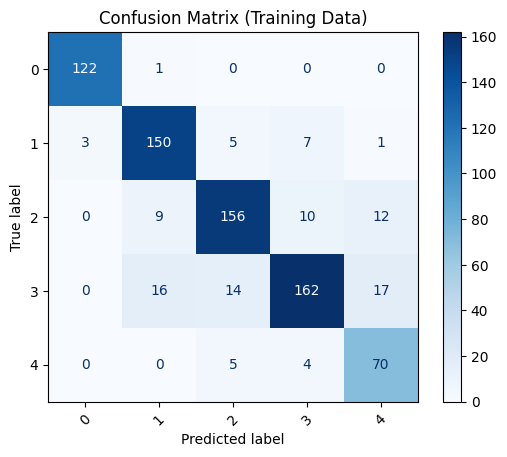

In [196]:

# Compute confusion matrix
cm = confusion_matrix(y, pipeline.predict(X_reduced), labels=np.unique(y))

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Training Data)")
plt.show()

In [202]:
file_path = 'D:/TCGA alighned/Celligner_aligned_data.csv'

def custom_predict(clf, X):
    y_proba = clf.predict_proba(X)  # 予測確率を取得
    y_pred = [4 if proba[4] > 0.3 else np.argmax(proba) for proba in y_proba]
    return np.array(y_pred)

# 1. Get the *names* of the selected gene columns from training
original_gene_cols = df_exp_dep.columns
selected_gene_names = original_gene_cols[sorted(selected)].tolist()
selected_gene_names_set = set(selected_gene_names)

# 2. Read the header of the prediction file to get all column names
try:
    file_cols = pd.read_csv(file_path, nrows=0).columns
    # Get the name of the index column (assumed to be the first col)
    index_col_name = file_cols[0] 
    file_gene_cols_set = set(file_cols[1:])
except Exception as e:
    print(f"Error reading header from {file_path}: {e}")
    raise

# 3. Check that all required genes exist in the file
missing_genes = selected_gene_names_set - file_gene_cols_set
if missing_genes:
    print("="*50)
    print("FATAL ERROR: DATA MISMATCH")
    print(f"The model was trained on gene columns that are MISSING from {file_path}.")
    print(f"Missing genes: {list(missing_genes)}")
    print("="*50)
    raise KeyError(f"Missing required columns in prediction file: {list(missing_genes)}")

# 4. Define the *full* list of columns to read
cols_to_read = [index_col_name] + selected_gene_names

# 5. Create lineage lookup dictionary for speed
lineage_col_index = {col_name: i for i, col_name in enumerate(lineage_cols)}
results = []

print("Starting chunked prediction...")

# 6. Read the file in chunks using the correct column names
for chunk in tqdm.tqdm(pd.read_csv(
    file_path,
    index_col=index_col_name,  # Use the *name* of the index column
    chunksize=1000,
    iterator=True,
    usecols=cols_to_read       # Read *both* index and selected genes
)):

    X_gene_chunk = chunk[selected_gene_names].values
    X_gene_chunk = scaler.transform(X_gene_chunk)
    X_lineage_chunk = np.zeros((len(chunk), len(lineage_cols)), dtype=int)

    for i, row_index in enumerate(chunk.index):
        lin = id_to_lineage.get(row_index)
        sub = id_to_subtype.get(row_index)

        if lin in lineage_col_index:
            col_idx = lineage_col_index[lin]
            X_lineage_chunk[i, col_idx] = 1

        if sub in lineage_col_index:
            col_idx = lineage_col_index[sub]
            X_lineage_chunk[i, col_idx] = 1

    # C. Combine gene and lineage features in the correct order
    X_chunk_reduced = np.hstack([X_gene_chunk, X_lineage_chunk])

    # --- Make predictions ---
    # Use the standard .predict() method
    #y_pred = custom_predict(pipeline, X_chunk_reduced)
    y_pred = pipeline.predict(X_chunk_reduced) 
    
    results.extend(zip(chunk.index, y_pred))

# 7. Create the final results DataFrame
results_df = pd.DataFrame(results, columns=['Index', 'Prediction'])

print("\nPrediction complete.")
print(results_df.head())

Starting chunked prediction...


14it [00:14,  1.05s/it]


Prediction complete.
                      Index  Prediction
0             TH27_1241_S01           0
1  TARGET-40-0A4I65-01A-01R           2
2            THR24_1965_S01           2
3            THR24_2080_S01           2
4            THR20_0494_S01           0


In [204]:
results_df['lineage'] = results_df['Index'].map(id_to_lineage)
results_df['UMAP_1'] = info['UMAP_1'].values
results_df['UMAP_2'] = info['UMAP_2'].values
results_df['cls'] = info['cluster'].values

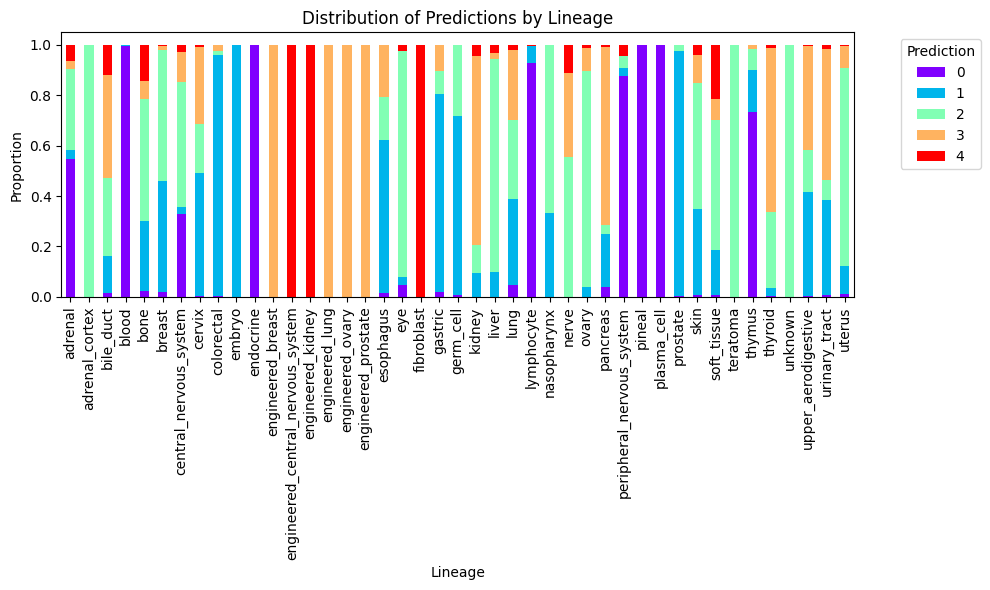

In [206]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure lineage and Prediction exist
if 'lineage' not in results_df.columns or 'Prediction' not in results_df.columns:
    raise ValueError("Missing 'lineage' or 'Prediction' column in results_df")

# 1. Count predictions per lineage
counts = results_df.groupby(['lineage', 'Prediction']).size().unstack(fill_value=0)

# 2. Convert to proportions (optional)
proportions = counts.div(counts.sum(axis=1), axis=0)

# 3. Plot stacked bar chart
proportions.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='rainbow',
)
results_df.index = results_df['Index']

plt.ylabel('Proportion')
plt.xlabel('Lineage')
plt.title('Distribution of Predictions by Lineage')
plt.legend(title='Prediction', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


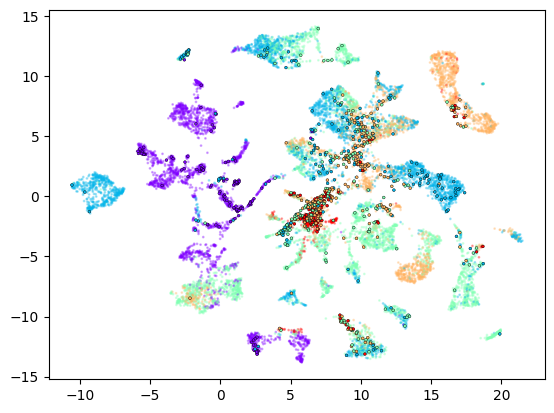

In [207]:
results_ach = results_df[results_df['Index'].str.contains('ACH-')]
plt.scatter(results_df['UMAP_1'], results_df['UMAP_2'], c=results_df['Prediction'], cmap='rainbow', s=1, alpha = 0.3)
plt.scatter(results_ach['UMAP_1'], results_ach['UMAP_2'], c=results_ach['True'], cmap='rainbow', s=4, edgecolors='black',linewidths=0.3)


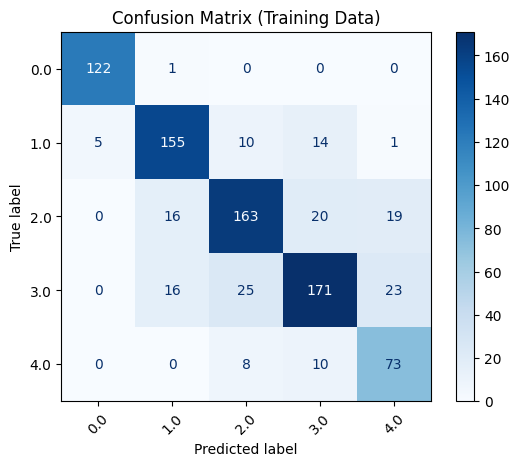

In [208]:

# Compute confusion matrix
r = results_ach.dropna()
cm = confusion_matrix(r['True'], r['Prediction'], labels=np.unique(r['True']))

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(r['True']))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Training Data)")
plt.show()

In [205]:
id_to_cls = {idx: cls for idx, cls in zip(cluster.index, cluster['Cluster'])}
results_df['True'] = [id_to_cls.get(idx, None) for idx in results_df['Index']]

In [ ]:
info

In [ ]:
# Predict on large TCGA data in chunks
file_path = 'D:/TCGA alighned/Celligner_aligned_data.csv'
#Download from https://figshare.com/articles/dataset/Celligner_data/11965269/4
import tqdm
results = []
relevant_cols = [d for d in df_exp_dep.columns]
for chunk in tqdm.tqdm(pd.read_csv(file_path, index_col=0, chunksize=100, iterator=True)):
    if relevant_cols:
        X_chunk = chunk[relevant_cols].values
        y_pred = custom_predict(pipeline, X_chunk)
        results.extend(zip(chunk.index, y_pred))

results_df = pd.DataFrame(results, columns=['Index', 'Prediction'])

### Kaplan Mier

In [ ]:
cancer_to_lin = {
    "Adrenal Cancer": "Adrenal Gland",
    "Bile Duct Cancer": "Biliary Tract",
    "Bladder Cancer": "Bladder/Urinary Tract",
    "Bone Cancer": "Bone",
    "Brain Cancer": "CNS/Brain",
    "Breast Cancer": "Breast",
    "Cervical Cancer": "Cervix",
    "Colon/Colorectal Cancer": "Bowel",
    "Endocrine Cancer": "Other",
    "Endometrial/Uterine Cancer": "Uterus",
    "Engineered": "Other",
    "Esophageal Cancer": "Esophagus/Stomach",
    "Eye Cancer": "Eye",
    "Fibroblast": "Fibroblast",
    "Gallbladder Cancer": "Biliary Tract",
    "Gastric Cancer": "Esophagus/Stomach",
    "Germ Cell Cancer": "Embryonal",
    "Head and Neck Cancer": "Head and Neck",
    "Kidney Cancer": "Kidney",
    "Leukemia": "Myeloid",
    "Liposarcoma": "Soft Tissue",
    "Liver Cancer": "Liver",
    "Lung Cancer": "Lung",
    "Lymphoma": "Lymphoid",
    "Myeloma": "Myeloid",
    "Nasopharyngeal Cancer": "Head and Neck",
    "Nerve": "Peripheral Nervous System",
    "Neuroblastoma": "Peripheral Nervous System",
    "Ovarian Cancer": "Ovary/Fallopian Tube",
    "Pancreatic Cancer": "Pancreas",
    "Pineal Cancer": "CNS/Brain",
    "Prostate Cancer": "Prostate",
    "Rhabdoid": "Soft Tissue",
    "Sarcoma": "Soft Tissue",
    "Skin Cancer": "Skin",
    "Teratoma": "Embryonal",
    "Thymus Cancer": "Other",
    "Thyroid Cancer": "Thyroid",
    "Unknown": "Other"
}


In [ ]:
import pandas as pd

df_info = pd.read_csv("D:/TCGA alighned/Celligner_info.csv",index_col=0)
df_clinical = (pd.merge(df_info, results_df, left_index=True, right_index=True))
df_clinical["lineage_new"] = [cancer_to_lin[c] for c in df_clinical["disease"]]
df_clinical_tumor = df_clinical[df_clinical["type"]=="tumor"].copy()


In [ ]:
results_df

In [ ]:

cluster_counts = pd.read_csv("../../dep/cluster_counts_dep.csv",index_col=0)
# 各がんタイプの合計行数を計算
total_counts = cluster_counts.groupby('Model')['count'].sum().reset_index(name='total')

# クラスター4の行数のみを取得
cluster_4_counts = cluster_counts[cluster_counts['Cluster'] == 4][['Model', 'count']]

# クラスター4の割合を計算
cluster_4_ratio = pd.merge(cluster_4_counts, total_counts, on='Model', how='right').fillna(0)
cluster_4_ratio['ratio'] = cluster_4_ratio['count'] / cluster_4_ratio['total']
cluster_4_ratio.index = cluster_4_ratio["Model"]

In [ ]:
a = df_clinical_tumor[["sampleID_CCLE_Name","lineage_new"]].groupby('lineage_new').count()
b = df_clinical_tumor[df_clinical_tumor["Prediction"]==4][["Prediction","lineage_new"]].groupby('lineage_new').count()
c = a.join(b).fillna(0)
c["ratio_clin"] = c["Prediction"]/c["sampleID_CCLE_Name"]
d = c.join(cluster_4_ratio)
#cluster_4_ratio_clin
import matplotlib.pyplot as plt
import numpy as np
d = d.dropna()
plt.figure(figsize=(5,5))
plt.scatter(d["ratio"],d["ratio_clin"])
plt.plot([-0.05, 0.4], [-0.05, 0.4], color='purple', linestyle='-', linewidth=2, label='Custom Line')
plt.savefig("kde_plot_no_margin.svg", dpi=300)
print(np.corrcoef(d["ratio"],d["ratio_clin"]))

In [ ]:
plt.scatter(df_clinical["UMAP_1_x"],df_clinical["UMAP_2_x"],s=2,c=[i == 4 for i in df_clinical["Prediction"]],cmap="Accent")
plt.colorbar()

In [ ]:
df_clinical

In [ ]:
d.sort_values("ratio_clin", ascending=False)

In [ ]:
df_death = pd.read_table("../../dep/clinical.cohort.2024-08-27/clinical.tsv",encoding='ISO-8859-1')
id_to_days = {}
for id,days in zip(df_death["case_submitter_id"],df_death["days_to_death"]):
    if days == "'--":continue
    id_to_days[id] = days
id_to_follow = {}
for id,days in zip(df_death["case_submitter_id"],df_death["days_to_last_follow_up"]):
    if days == "'--":continue
    id_to_follow[id] = days
submitter_id = ["-".join(i.split("-")[:-1]) for i in df_clinical_tumor.index]
#dfk.columns=["a"]
#df_clinical["AMOTL2"] = dfk["a"].tolist()
df_clinical_tumor = df_clinical[df_clinical["type"]=="tumor"].copy()
df_clinical_tumor["days"] = [id_to_days.get(i,"ND") for i in submitter_id]
df_clinical_tumor["follow"] = [id_to_follow.get(i,"ND") for i in submitter_id]

In [ ]:
df_survival = df_clinical_tumor[(df_clinical_tumor["days"] != "ND") | (df_clinical_tumor["follow"] != "ND")]

df_survival = df_survival[df_survival["lineage_x"]=="kidney"]
#df_survival = df_survival[df_survival["lineage_x"]=="lung"]


data = {"time":[],"event":[],"group":[]}#,"amot":[]}
for d, f in zip(df_survival["days"],df_survival["follow"]):
    if d=="ND":
        data["time"].append(int(f))
        data["event"].append(0)
    else:
        data["time"].append(int(d))
        data["event"].append(1)
#df_survival["Prediction"].quantile(0.8)
data["group"] = ["A" if s >= 3 else "B" for s in df_survival["Prediction"]]
data["group"] = df_survival["Prediction"]
#data["amot"]  = df_survival["AMOTL2"]
#

In [ ]:
df_clinical.lineage_x.unique()

In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test

df = pd.DataFrame(data)

# Kaplan-Meierフィッターを初期化

kmf = KaplanMeierFitter()

# グループAのカプラン–マイヤー曲線を作成
kmf.fit(durations=df[df['group'] != 4]['time'], event_observed=df[df['group'] != 4]['event'], label='Group A')
ax = kmf.plot_survival_function()

# グループBのカプラン–マイヤー曲線を追加
kmf.fit(durations=df[df['group'] == 4]['time'], event_observed=df[df['group'] == 4]['event'], label='Group B')
kmf.plot_survival_function(ax=ax)

# グラフを表示
plt.title("Kaplan-Meier Curve")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

# ログランク検定
results = logrank_test(
    df[df['group'] != 4]['time'], df[df['group'] == 4]['time'],
    event_observed_A=df[df['group'] != 4]['event'],
    event_observed_B=df[df['group'] == 4]['event']
)

# 検定結果を表示
print(f"Log-rank Test p-value: {results.p_value}")
print(f"Test Statistic: {results.test_statistic}")

In [ ]:
import pandas as pd
from lifelines.statistics import logrank_test

# データフレームを適切にフィルタリング
df_survival = df_clinical_tumor[(df_clinical_tumor["days"] != "ND") | (df_clinical_tumor["follow"] != "ND")]

# Lineageごとにログランク検定を実行
lineages = df_survival["lineage_new"].unique()
p_values = {}

for lineage in lineages:
    df_lineage = df_survival[df_survival["lineage_new"] == lineage]
    
    data = {"time": [], "event": [], "group": []}
    for d, f in zip(df_lineage["days"], df_lineage["follow"]):
        if d == "ND":
            data["time"].append(int(f))
            data["event"].append(0)
        else:
            data["time"].append(int(d))
            data["event"].append(1)
    
    # Grouping by median
    data["group"] = ["A" if s != 4 else "B" for s in df_lineage["Prediction"]]

    # Convert to DataFrame for easier processing
    df_data = pd.DataFrame(data)
    
    # Log-rank test between groups A and B
    results = logrank_test(
        df_data[df_data["group"] == "A"]["time"],
        df_data[df_data["group"] == "B"]["time"],
        event_observed_A=df_data[df_data["group"] == "A"]["event"],
        event_observed_B=df_data[df_data["group"] == "B"]["event"]
    )
    
    # Store the p-value
    p_values[lineage] = results.p_value

# 結果を表示
for lineage, p_value in p_values.items():
    print(f"{lineage}: p-value = {p_value}")


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('logistic', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, C=0.001))
])

pipeline.fit(X, y)

def custom_predict(clf, X):
    y_proba = clf.predict_proba(X) 
    y_pred = [4 if proba[4]>0.3 else np.argmax(proba) for proba in y_proba]
    return np.array(y_pred)     

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier 

file_path = 'D:/TCGA alighned/Celligner_aligned_data.csv'
#Download from https://figshare.com/articles/dataset/Celligner_data/11965269/4

# 結果を保存するためのリスト
results = []
relevant_cols = [d[:-2] for d in df_merge2.columns]
# 100列ずつデータを読み込んで処理
for chunk in tqdm(pd.read_csv(file_path, index_col=0, chunksize=100, iterator=True)):
    # 指定された列だけを抽出
    #relevant_cols = [col for col in cols if col in chunk.columns]
    
    if relevant_cols:
        X = chunk[relevant_cols].values
        
        # Clfを使って予測
        y_pred = custom_predict(pipeline, X)
        
        # Indexと予測結果を保存
        results.extend(zip(chunk.index, y_pred))

# 結果をデータフレームとして保存
results_df = pd.DataFrame(results, columns=['Index', 'Prediction'])